In [16]:
print(df.shape)


(3000, 30)


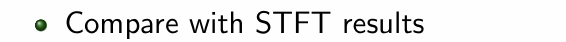

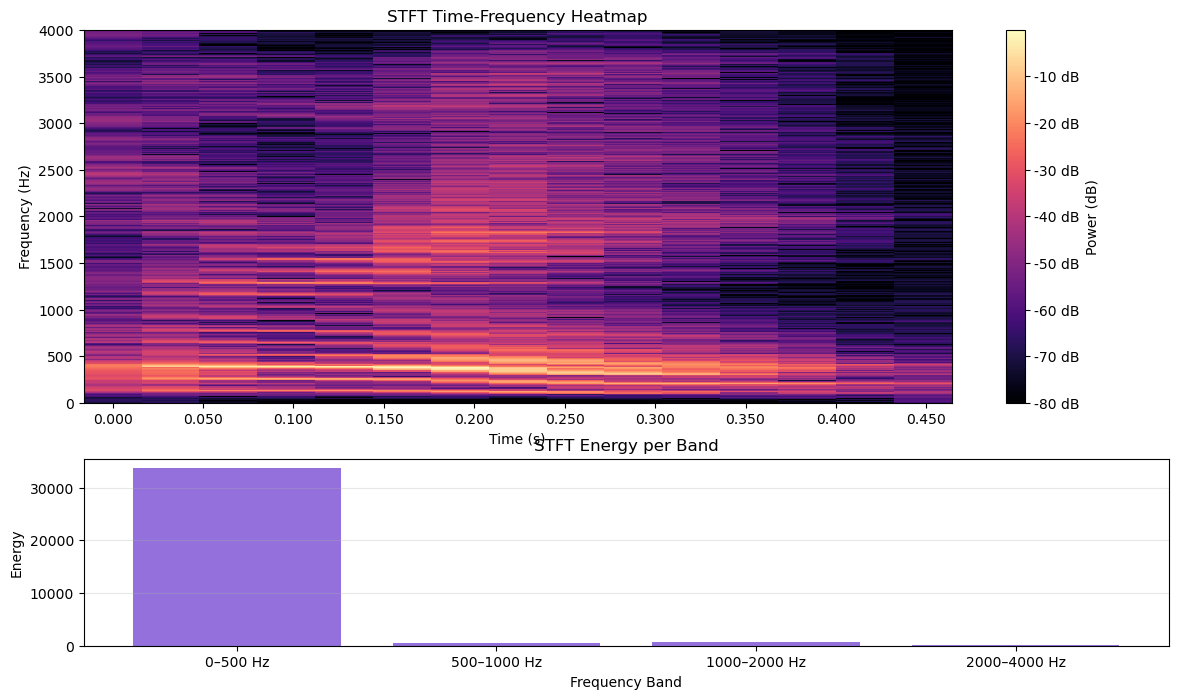

<Figure size 800x400 with 0 Axes>

In [57]:
## STFT


import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# File selection
dataset_path = "./free-spoken-digit-dataset-master/recordings"
filename = "3_jackson_15.wav"
filepath = os.path.join(dataset_path, filename)

# Load audio file
audio, sr = librosa.load(filepath, sr=None)
sr = 8000
# Duration and time vector
duration = len(audio) / sr
t = np.linspace(0, duration, len(audio))

#  STFT Parameters
n_fft = 1024
hop_length = 256
stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
stft_magnitude = np.abs(stft_result)

# Linear-scale energy per frequency bin (sum over time)
stft_band_energy = np.sum(stft_magnitude**2, axis=1)

stft_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

freqs = np.linspace(0, sr/2, len(stft_band_energy))  # Map bin index to Hz

# -------------------------------
#  Plot STFT Heatmap + Energy
# -------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [2, 1]})

#  Heatmap (Time-Frequency)
img = librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', ax=ax1)
ax1.set_title("STFT Time-Frequency Heatmap")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
fig.colorbar(img, ax=ax1, format='%+2.0f dB', label="Power (dB)")



# Group STFT energy into 4 bands to match DWT
bands = {
    "0–500 Hz": (0, 500),
    "500–1000 Hz": (500, 1000),
    "1000–2000 Hz": (1000, 2000),
    "2000–4000 Hz": (2000, 4000)
}

band_energies = []
band_labels = []

for label, (f_low, f_high) in bands.items():
    idx_band = np.where((freqs >= f_low) & (freqs < f_high))[0]
    energy = np.sum(stft_band_energy[idx_band])
    band_energies.append(energy)
    band_labels.append(label)

#  Plot grouped STFT energy (similar to DWT bar chart)
plt.figure(figsize=(8, 4))
ax2.bar(band_labels, band_energies, color='mediumpurple')
ax2.set_title("STFT Energy per Band")
ax2.set_xlabel("Frequency Band")
ax2.set_ylabel("Energy")
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

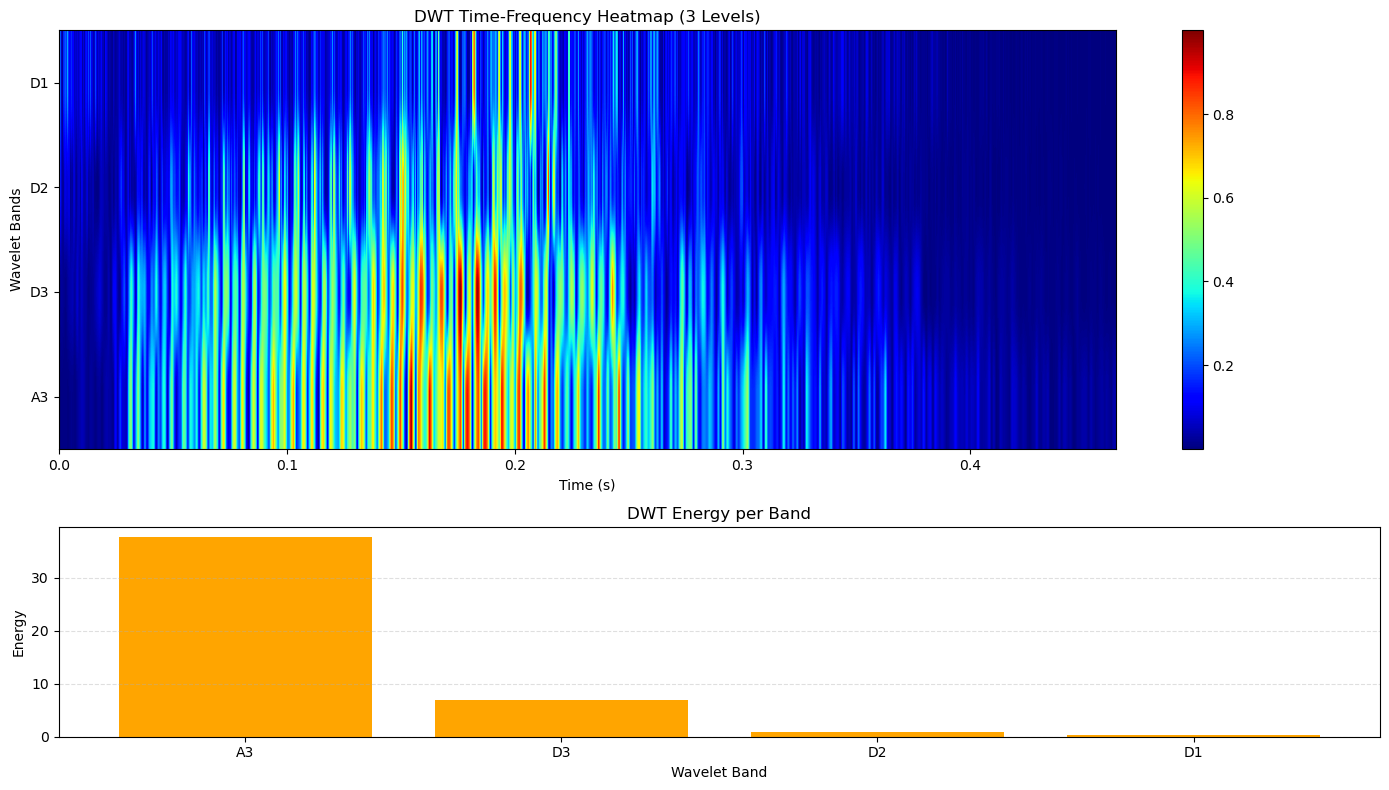

In [31]:
# DWT , for the purpose of comparison

import numpy as np
import matplotlib.pyplot as plt
import pywt
import librosa
import os

# -----------------------
#  Load Audio File
# -----------------------
dataset_path = "./free-spoken-digit-dataset-master/recordings"
filename = "3_jackson_15.wav"
filepath = os.path.join(dataset_path, filename)

# Load audio
audio, sr = librosa.load(filepath, sr=None)
duration = len(audio) / sr
t = np.linspace(0, duration, len(audio))

# -----------------------
#  Apply DWT
# -----------------------
wavelet = 'db4'
level = 3
coeffs = pywt.wavedec(audio, wavelet=wavelet, level=level)

# Separate approx and details
approx = coeffs[0]       # A3
details = coeffs[1:]     # [D3, D2, D1]

# Labels: A3 at bottom, D3→D1 upward
dwt_band_labels = [f"A{level}"] + [f"D{i}" for i in range(level, 0, -1)]

# -----------------------
#  Energy per Band
# -----------------------
dwt_energies = [np.sum(approx**2)] + [np.sum(d**2) for d in details]

# -----------------------
#  Build DWT Time-Frequency Matrix
# -----------------------
n_levels = level + 1
coeff_matrix = np.zeros((n_levels, len(audio)))

# Order: A3 (bottom), D3, D2, D1 (top)
coeff_order = [approx] + details

for i, coeff in enumerate(coeff_order):
    coeff_time = np.linspace(0, duration, len(coeff))
    interp = np.interp(t, coeff_time, np.abs(coeff))
    coeff_matrix[i, :] = interp / (np.max(interp) + 1e-8)

# -----------------------
#  Plot Heatmap + Energy
# -----------------------
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

#  DWT Heatmap
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(coeff_matrix, aspect='auto', origin='lower',
                extent=[0, duration, 0, n_levels], cmap='jet')
ax1.set_title("DWT Time-Frequency Heatmap (3 Levels)")
ax1.set_yticks(np.arange(n_levels) + 0.5)
ax1.set_yticklabels(dwt_band_labels)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Wavelet Bands")
plt.colorbar(im, ax=ax1)








# Energy Bar Chart
ax2 = fig.add_subplot(gs[1])
ax2.bar(dwt_band_labels, dwt_energies, color='orange')
ax2.set_title("DWT Energy per Band")
ax2.set_xlabel("Wavelet Band")
ax2.set_ylabel("Energy")
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


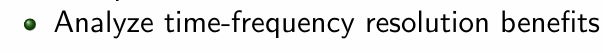

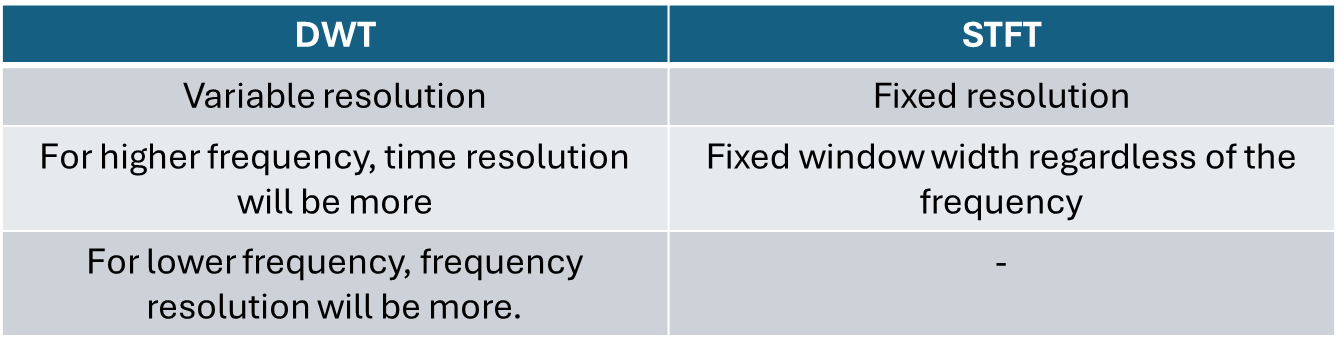
